In [34]:
library(nat)
library(nat.nblast)

In [6]:
# Set paths for neurons and NBLAST
nrn.dir.path <- "/home/zack/Desktop/Lab_Work/Data/neuron_morphologies/Zebrafish/aligned_040120/Zbrain_neurons_flipped_right"
nblast.output.path <- "/home/zack/Desktop/Lab_Work/Projects/neuron-morphology-classifier/data/nblast"

In [4]:
# Read in the neurons
nrns <- read.neurons(nrn.dir, format="swc")

ERROR: Error in read.neurons(nrn.dir, format = "swc"): could not find function "read.neurons"


In [16]:
# Convert neurons to dotprops 
nrns.dps <- dotprops(nrns, stepsize=1, OmitFailures=TRUE)

In [45]:
# Perform NBLAST all-by-all scoring and save to a .csv file
nrn.scores <- nblast_allbyall(nrns.dps, distance=TRUE, normalisation="mean")
write.csv(nrn.scores, paste(nblast.output.path, "/nblast_aba_norm_mean_distance_060920.csv", sep=""), row.names = TRUE)

When converting the neurons to the dotprops (dps) representation, I used the same arguments to the `dotprops()` function as Dr. Kunst used in his paper. However, when calling `nblast_allbyall()`, I used all the same arguments except I set `distance=TRUE`. This is because the `cmdscale()` implimentation of mulitdimensional scaling in R requires a dissimilarity matrix rather than a similarity matrix. The output of `nblast_allbyall()` is by default a score matrix, which is a form of similarity matrix. Therefore, I `distance=TRUE` to get a distance matrix as the output, which is a form of dissimilarity matrix. 

In [1]:
lbl.path <- "/home/zack/Desktop/Lab_Work/Projects/neuron-morphology-classifier/data/neurons/MPIN_040120/metadata.csv"
nrn.dists.path <- "/home/zack/Desktop/Lab_Work/Projects/neuron-morphology-classifier/data/nblast/nblast_aba_mean_norm_distance_060920.csv"
nrn.dists <- read.csv(file=nrn.dists.path, row.names=1)

In [34]:
# Perform multidimensional scaling on the distance matrix
mds.fit <- cmdscale(nrn.dists, eig=TRUE, k=5)

In [35]:
# Read in the neuron metadata
lbl.df <- read.csv(file=lbl.path)

# Edit all the row names for merging with mds.fit$points
lbl.df$Neuron_name <- paste0(lbl.df$Neuron_name, ".swc")
row.names(lbl.df) <- lbl.df$Neuron_name

# Merge the labels with mds.fit$points
points <- as.data.frame(mds.fit$points)
plot.df <- merge(points,lbl.df[c("cell_type","gal4")], by="row.names", all=TRUE)

# Convert datatypes of columns from factors to strings
fct.cols <- sapply(plot.df, is.factor)
plot.df[,fct.cols] <- sapply(plot.df[,fct.cols], as.character)

# Check results
head(plot.df)

,Row.names,V1,V2,V3,V4,V5,cell_type,gal4
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,20150327_1013_BGUG_HuC_ltRFP_d5_F2.swc,0.13910267,-0.5550695,-0.25440979,0.13839882,0.08556119,PVPN Class 3,s1013tET
2,20150402_1013_BGUG_HuC_ltRFP_d5_F3.swc,0.28128859,-0.4230209,-0.47328761,0.18080868,0.14423815,PVPN Class 3,s1013tET
3,20160512_1013_BGUG_HuC_ltRFP_d6_F6_Neuron2.swc,0.08056456,-0.5817235,-0.26444687,0.10982740,0.13622997,PVPN Class 3,s1013tET
4,20160519_1013_BGUG_HuC_ltRFP_d6_F1.swc,0.06127568,-0.6636909,-0.04727542,-0.16621728,-0.11006489,PVPN Class 1,s1013tET
5,20160519_1013_BGUG_HuC_ltRFP_d6_F6.swc,0.08260032,-0.6514123,-0.04009604,-0.11921497,-0.25640153,PVPN Class 1,s1013tET
6,20160526_1013_BGUG_HuC_ltRFP_d6_F2_Neuron1.swc,-0.04487396,-0.3016584,-0.12132706,0.02406155,0.20506150,PVPN Class 3,s1013tET


In [36]:
# Create neurotransmitter label groups
nt.lbls <- plot.df$gal4
nt <- NA
nt[nt.lbls!="vGlut2a" & nt.lbls!="Gad1b"] <- 1
nt[is.na(nt)] <- 1
nt[nt.lbls=="Gad1b (mpn155)"] <- 2
nt[nt.lbls=="vGlut2a"] <- 3

# Check that the numbers of each are roughly correct
table(nt)

nt
   1    2    3 
2916   64  139 

In [38]:
nt.colors <- c(rgb(0.8,0.8,0.8,0.2), "purple", "red")
nt.styles <- c(1, 15, 17, 18, 16)
nt.legend.txt <- c("Unknown", "Gad1b", "vGlut2a")

# Plot with neurotransmitter labels colored
png("colored_nt.png", width=10, height=10, units="in", res=600)
pairs(plot.df[,2:6],
      main="Title",
      col=nt.colors[nt],
      pch=nt.styles[nt],
      oma=c(3,3,3,15))
par(xpd=TRUE)
legend("topright", fill=c(rgb(0.8,0.8,0.8,0.3), "purple", "red"), legend=nt.legend.txt)
dev.off()

png 
  2

In [6]:
# Create cell type label groups
ct.lbls <- plot.df$cell_type
ct <- NA
ct[is.na(ct.lbls)] <- 1
ct[grep('PVPN', ct.lbls, fixed=FALSE)] <- 2
ct[ct.lbls=="Eurydendroid Cells"] <- 3
ct[ct.lbls=="Mitral Cells"] <- 4
ct[ct.lbls=="Retinal Ganglion Cells"] <- 5

# Check that the numbers of each are roughly correct
table(ct)

ct
   1    2    3    4    5 
2752  154  116   55   42 

In [39]:
ct.colors <- c(rgb(0.8,0.8,0.8,0.2), "purple", "red", "blue", "orange")
ct.styles <- c(1, 15, 17, 18, 16)
ct.legend.txt <- c("Unkown", "PVPN Cells", "Eurydendroid Cells", "Mitral Cells", "Retinal Ganglion Cells")

# Plot with neurotransmitter labels colored
png("colored_ct.png", width=10, height=10, units="in", res=600)
pairs(plot.df[,2:6],
     main="Title",
     col=ct.colors[ct],
     pch=ct.styles[ct],
     oma=c(3,3,3,22))
par(xpd=TRUE)
legend("topright", fill=ct.colors, legend=ct.legend.txt)
dev.off()

png 
  2

In [21]:
unique(ct.lbls)

[1] "PVPN Class 3"           "PVPN Class 1"           "PVPN Class 4"          
 [4] "PVPN Class 6b"          "PVPN"                   "PVPN Class 7"          
 [7] "PVPN Class 5"           "PVPN Class 6a"          "PVPN Class 2"          
[10] "Mitral Cells"           NA                       "Eurydendroid Cells"    
[13] "Retinal Ganglion Cells"

In [25]:
# Create PVPN subtype label groups
sct <- NA
sct[is.na(ct.lbls)] <- 1
sct[grep('PVPN Class 1', ct.lbls, fixed=FALSE)] <- 2
sct[grep('PVPN Class 2', ct.lbls, fixed=FALSE)] <- 3
sct[grep('PVPN Class 3', ct.lbls, fixed=FALSE)] <- 4
sct[grep('PVPN Class 4', ct.lbls, fixed=FALSE)] <- 5
sct[grep('PVPN Class 5', ct.lbls, fixed=FALSE)] <- 6
sct[grep('PVPN Class 6a', ct.lbls, fixed=FALSE)] <- 7
sct[grep('PVPN Class 6b', ct.lbls, fixed=FALSE)] <- 8
sct[grep('PVPN Class 7', ct.lbls, fixed=FALSE)] <- 9



# Check that the numbers of each are roughly correct
table(sct)

sct
   1    2    3    4    5    6    7    8    9 
2752   19    5   56    8   14    3    9   17 

In [42]:
sct.colors <- c(rgb(0.8,0.8,0.8,0.05), "purple", "red", "blue", "orange", "cyan", "magenta", "yellow", "brown")
sct.styles <- c(1, 3, 4, 15, 16, 17, 18)
sct.legend.txt <- c("Unkown", "PVPN Class 1", "PVPN Class 2","PVPN Class 3","PVPN Class 4",
                    "PVPN Class 5","PVPN Class 6a","PVPN Class 6b","PVPN Class 7")
# Plot with neurotransmitter labels colored
png("colored_sct.png", width=10, height=10, units="in", res=600)
pairs(plot.df[,2:6],
     main="Title",
     col=sct.colors[sct],
     pch=sct.styles[sct],
     oma=c(3,3,3,22))
par(xpd=TRUE)
legend("topright", fill=sct.colors, legend=sct.legend.txt)
dev.off()

png 
  2

In [8]:
#TODO plot the true vs projected point distances
d <- dist(plot.df[,2:4])

In [9]:
head(d)

[1] 0.29250841 0.06509909 0.24649603 0.24167093 0.34025811 0.42981697

In [10]:
eig.abs.sum <- sum(abs(mds.fit$eig))
eig.portions <- abs(mds.fit$eig)/eig.abs.sum
head(eig.portions)

[1] 0.05146128 0.04450563 0.03847660 0.03298301 0.02425898 0.02272584

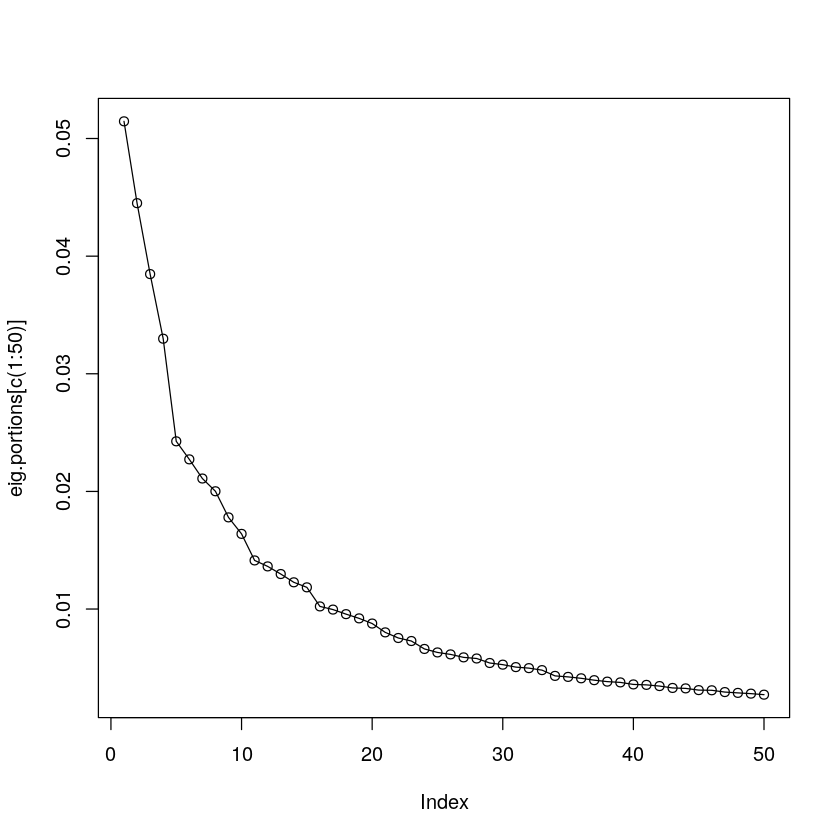

In [11]:
plot(eig.portions[c(1:50)], type='o')